In [1]:
# SETUP : importing

import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
import math

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.preprocessing import StandardScaler

import utilcompute as uc
from pprint import pprint


C:\Users\danis_p50\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# SETUP : reading in the datasets

data = np.column_stack( (load_boston().data, load_boston().target) )
df = pd.DataFrame(data)
df.columns = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
    'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'
]

print('df.shape[0] : ', df.shape[0])

df.shape[0] :  506


In [3]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [4]:
target = 'MEDV'
features = [c for c in df.columns if (c != target)]


In [5]:
# SHUFFLING 

seed = 10
np.random.seed(seed)

df = df.reindex(np.random.permutation(df.index))


In [6]:
def transform(df, included, excluded, scaler):
    
    return_conditions = (
        (df.empty) or
        (not included)
    )
    if (return_conditions):
        return
    
    scaler.fit(df[included])
    scaled_ndarray = scaler.transform(df[included])

    series_dict = {}
    for c_index in range(0, len(included)):
        name = included[c_index]
        source = pd.Series(data = scaled_ndarray[:,c_index], name = name) 
        series_dict[name] = source

    if (excluded):
        # here it's important to reset the index of the non-standardized columns before adding them to the new dataframe :
        # when we created the standardized Series from the ndarray, those were created from scratch, their index starts from 0,
        # whereas the excluded columns still have their original index:
        # what happens if we added the latter without resetting the index ?
        # the included feature will index in (say) [0 - 99], the excluded ones in (say) [200-299], 
        # and pandas will fill up all the rows in [100-199] with missing values !!! 
        # at the end we have (say) 300 rows instead of (say) 100 !!!        
        series_dict.update({exc : df[exc].reset_index(drop = True) for exc in excluded}) 
    
    for key, value in series_dict.items():
        index_list = df.index.values.tolist()
        
    df_result = pd.DataFrame(data = series_dict)
    
    # since series_dict presents its own elements not by insertion order but by key alphabetical order, it happens that
    # instead of [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
    # we get     [Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Outcome, Pregnancies, SkinThickness]
    
    df_result = df_result[df.columns.tolist()]
    
    return df_result


In [7]:
# STANDARDIZATION

df_std = transform(df = df, included = features, excluded = [target], scaler = StandardScaler())


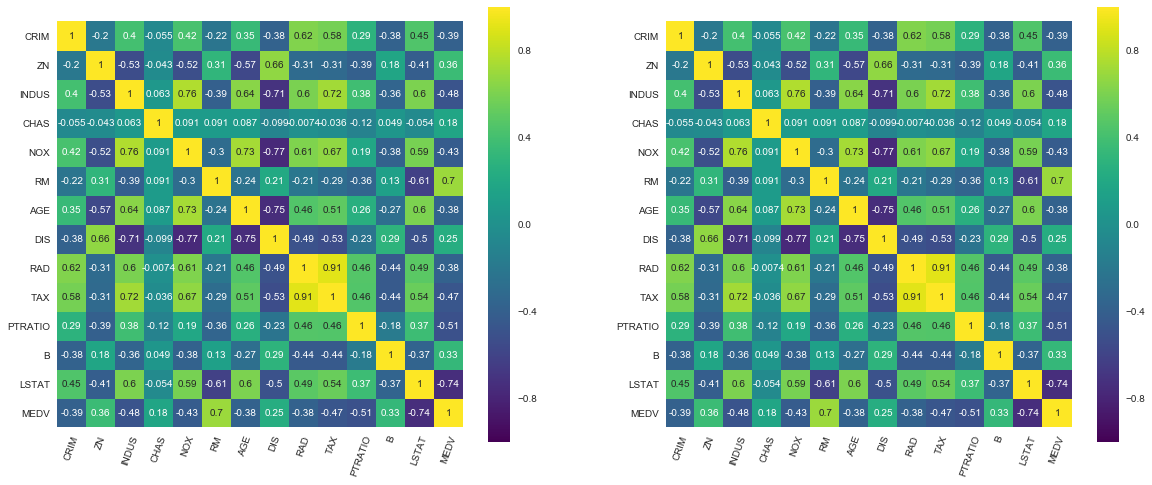

In [8]:
# CORRELATION MATRIX

f, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))

sns.heatmap(df.corr(), cmap = 'viridis', square=True, annot = True, annot_kws={'size': 10}, ax = axs[0])
sns.heatmap(df_std.corr(), cmap = 'viridis', square=True, annot = True, annot_kws={'size': 10}, ax = axs[1])

for ax in axs:
    for label in ax.get_xticklabels():
        label.set_rotation(70)

plt.show()   


In [9]:
vif_dict = uc.compute_vif(df = df, features = features)
print('df : ')
print()
pprint(vif_dict)

print()

vif_dict = uc.compute_vif(df = df_std, features = features)
print('df_std : ')
print()
pprint(vif_dict)


df : 

{'AGE': 21.386773583047781,
 'B': 20.066007061121244,
 'CHAS': 1.1528909172683364,
 'CRIM': 2.074625763252568,
 'DIS': 14.699368125642422,
 'INDUS': 14.48428343503152,
 'LSTAT': 11.088865100659874,
 'NOX': 73.902211708121285,
 'PTRATIO': 85.027313520427597,
 'RAD': 15.154741587164722,
 'RM': 77.934968671814261,
 'TAX': 61.226929320337554,
 'ZN': 2.8438903527570774}

df_std : 

{'AGE': 3.1008597090649364,
 'B': 1.3458321362245254,
 'CHAS': 1.073942576235468,
 'CRIM': 1.7733207336404868,
 'DIS': 3.9565506707875113,
 'INDUS': 3.9911944587426742,
 'LSTAT': 2.9381269138596409,
 'NOX': 4.3950638803302251,
 'PTRATIO': 1.7992202856110955,
 'RAD': 7.48053920326217,
 'RM': 1.9341610244158234,
 'TAX': 9.0084721742418967,
 'ZN': 2.2986411129153472}


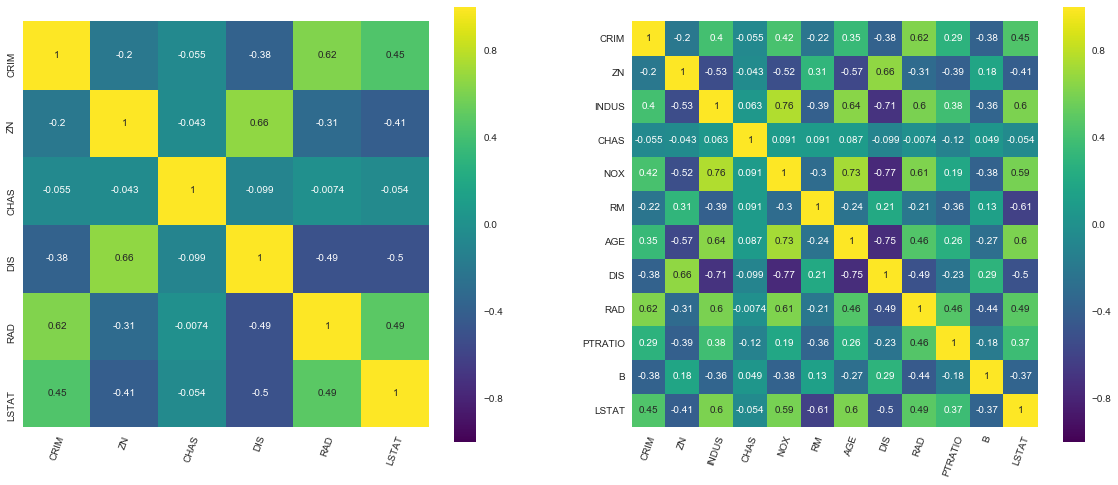

In [10]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))

selected_features_1 = uc.vif_best_subset_selection(
    vif_threshold = 5, df = df, features = features, level = len(features), debug = False)
selected_features_2 = uc.vif_best_subset_selection(
    vif_threshold = 5, df = df_std, features = features, level = len(features), debug = False)

df = df[selected_features_1]
df_std = df_std[selected_features_2]

sns.heatmap(df.corr(), cmap = 'viridis', square=True, annot = True, annot_kws={'size': 10}, ax = axs[0])
sns.heatmap(df_std.corr(), cmap = 'viridis', square=True, annot = True, annot_kws={'size': 10}, ax = axs[1])

for ax in axs:
    for label in ax.get_xticklabels():
        label.set_rotation(70)

plt.show()


In [11]:
vif_dict = uc.compute_vif(df = df, features = selected_features_1)
print('df : ')
print()
pprint(vif_dict)

print()

vif_dict = uc.compute_vif(df = df_std, features = selected_features_2)
print('df_std : ')
print()
pprint(vif_dict)


df : 

{'CHAS': 1.0590149397937492,
 'CRIM': 2.0205604378835926,
 'DIS': 3.9348942526294448,
 'LSTAT': 4.24462499834413,
 'RAD': 3.7238318912633259,
 'ZN': 2.2367460323942336}

df_std : 

{'AGE': 3.0980757776499455,
 'B': 1.3448851698191651,
 'CHAS': 1.058173727155751,
 'CRIM': 1.7730878014022016,
 'DIS': 3.9550455740918151,
 'INDUS': 3.2255003166246246,
 'LSTAT': 2.9374269973290006,
 'NOX': 4.3706180121800529,
 'PTRATIO': 1.7889787057775797,
 'RAD': 2.8348548408146659,
 'RM': 1.9234813968393076,
 'ZN': 2.1841604262111982}


In [12]:
# CONCLUSIONS : IMPACT OF FEATURE STANDARDIZATION ON MULTICOLLINEARITY

# 1) both the standardized and non-standardized dataframes present the same correlation matrix

# 2) here is the key role of standardization in regard to multicollinearity:
#    since we know correlation and multicollinearity are different concepts, 
#    we also printed the VIF vectors of both dataframes and noticed that :
#     - the standardized dataframe present a VIF vector with very low multicollinearity (all < 5),
#       thus it retains all the original features even when subject to vif feature selection
#     - the non-standardized dataframe, in order to reduce multicollinearity, needs to go through
#       vif feature selection and loses (in this case) half of the original features


#2) [insert here]
